In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image

from sklearn import metrics

import cv2
import os

from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
# Harshal Pimpalshende

In [4]:
from zipfile import ZipFile
data_path = 'fer2013.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
print('The data set has been extracted.')


The data set has been extracted.


In [5]:
path = 'train'
classes = os.listdir('train')
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

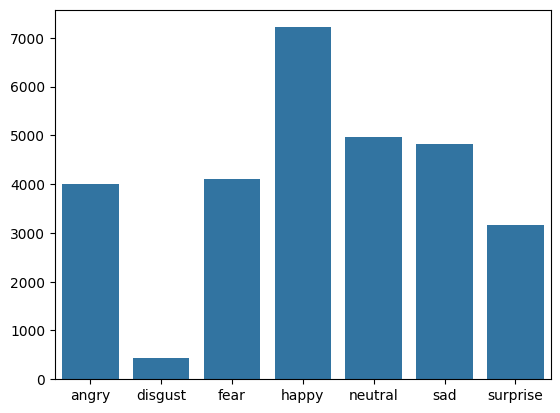

In [6]:
count = []
for cat in classes:
    count.append(len(os.listdir(f'{path}/{cat}')))

sb.barplot(x=classes, y=count)
plt.show()
# Ignore the error in this cell [ERROR :- "count.append(len(os.listdir(f'{path}/{cat}')))"]

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
		'train',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
		'test',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
emotions = list(train_gen.class_indices.keys())


In [9]:
model = keras.models.Sequential([
									layers.Conv2D(32,(3,3),activation='relu',input_shape=(48, 48, 1)),
									layers.Conv2D(64,(3,3),activation='relu'),
									layers.MaxPooling2D(2,2),


									layers.Flatten(),
									layers.Dense(64,activation='relu'),
									layers.BatchNormalization(),
									layers.Dense(32,activation='relu'),
									layers.Dropout(0.3),
									layers.BatchNormalization(),
									layers.Dense(7, activation='softmax')
])


In [10]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics=['accuracy']
)


In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached up to 90%, so stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [12]:
history = model.fit(train_gen,
					validation_data = val_gen,
					# Increase in the "epochs" count will result to, more accurate results and less loss ( More the epochs - more time it will consume)
                    epochs = 1,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


449/449 ━━━━━━━━━━━━━━━━━━━━ 420s 916ms/step - accuracy: 0.2735 - loss: 1.9603 - val_accuracy: 0.4118 - val_loss: 1.5631 - learning_rate: 0.0010


In [13]:
def plot_image(img, emoj):
	wmin = 256
	hmin = 256

	emoj = cv2.resize(emoj, (wmin, hmin))
	img = cv2.resize(img, (wmin, hmin))
	cv2.imshow('Images', cv2.hconcat([img, emoj]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


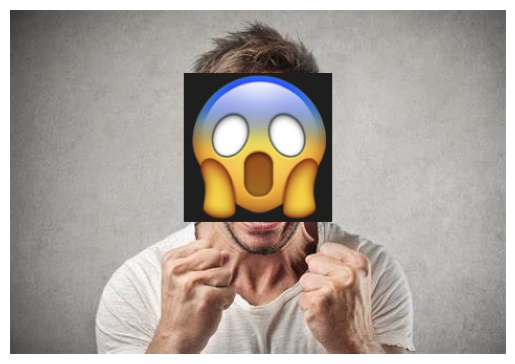

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image_with_emoji(image, emoji, x, y, w, h):
    # Resize emoji to fit the face region
    emoji_resized = cv2.resize(emoji, (w, h))
    
    # Overlay emoji on the image
    image[y:y+h, x:x+w] = emoji_resized

    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Load the face cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Read the image
img_path = r'C:\Users\Prasanna\Downloads\Emojify---Detect-emotion-from-human-face-ML-Project--main\Emojify---Detect-emotion-from-human-face-ML-Project--main\man.jpeg'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)

# Assuming model and classes are already defined and loaded
for (x, y, w, h) in faces:
    # Ensure the slicing coordinates are within the image bounds
    x_start = max(0, x)
    y_start = max(0, y)
    x_end = min(gray.shape[1], x + w - 10)
    y_end = min(gray.shape[0], y + h + 10)
    
    # Resize the face region
    face_region = gray[y_start:y_end, x_start:x_end]
    resized_face = cv2.resize(face_region, (48, 48))
    
    # Expand dimensions to match the model's input shape
    resized_face = np.expand_dims(resized_face, axis=-1)
    resized_face = np.expand_dims(resized_face, axis=0)

    # Predict the class of the face
    pred = model.predict(resized_face)
    idx = pred.argmax(axis=-1)[0]

    # Load the corresponding emoji
    emoji_path = f'emojis/{classes[idx]}.jpg'
    emoj = cv2.imread(emoji_path)

    # Plot the image with the emoji
    plot_image_with_emoji(img, emoj, x, y, w, h)


In [19]:
classes[idx]

'fear'